In [1]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import numpy as np
import matplotlib.pyplot as plt

# Example in Brain Age Prediction

Label shape: torch.Size([1, 40])
Input data shape: torch.Size([1, 1, 160, 192, 160])
dtype: torch.float32
Output shape: torch.Size([1, 40])


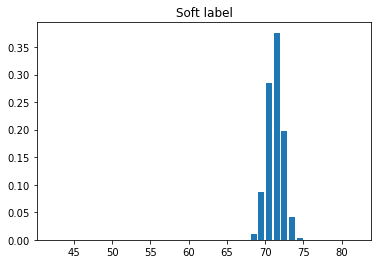

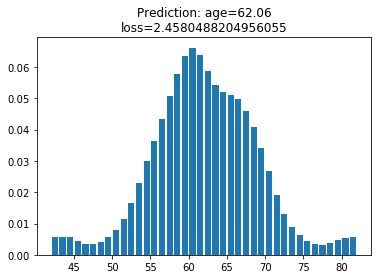

In [2]:
# Example
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'
model.load_state_dict(torch.load(fp_))
model.cuda()

# Example data: some random brain in the MNI152 1mm std space
data = np.random.rand(182, 218, 182)
label = np.array([71.3,]) # Assuming the random subject is 71.3-year-old.

# Transforming the age to soft label (probability distribution)
bin_range = [42,82]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# Preprocessing
data = data/data.mean()
data = dpu.crop_center(data, (160, 192, 160))

# Move the data from numpy to torch tensor on GPU
sp = (1,1)+data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32).cuda()
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model(input_data)

# Output, loss, visualisation
x = output[0].cpu().reshape([1, -1])
print(f'Output shape: {x.shape}')
loss = dpl.my_KLDivLoss(x, y).numpy()

# Prediction, Visualisation and Summary
x = x.numpy().reshape(-1)
y = y.numpy().reshape(-1)

plt.bar(bc, y)
plt.title('Soft label')
plt.show()

prob = np.exp(x)
pred = prob@bc
plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()